In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.outliers_influence import OLSInfluence as olsi
from statsmodels.stats.diagnostic import het_breuschpagan
from patsy import dmatrices
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2 
from user_definition import *

#### Link
https://www.kaggle.com/datasets/shivam2503/diamonds?resource=download

#### Content

<b>price:</b> price in US dollars (\$326--\$18,823)

<b>carat:</b> weight of the diamond (0.2--5.01)

<b>cut:</b> quality of the cut (Fair, Good, Very Good, Premium, Ideal)

<b>color:</b> diamond colour, from J (worst) to D (best)

<b>clarity:</b> a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

<b>x:</b> length in mm (0--10.74)

<b>y:</b> width in mm (0--58.9)

<b>z:</b> depth in mm (0--31.8)

<b>depth:</b> total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

<b>table</b> width of top of diamond relative to widest point (43--95)

# Pulling from PostgreSQL

Let's fetch the data from the local postgreSQL database

In [2]:
connection = psycopg2.connect(database="postgres",
                        user=postgres_user, password=postgres_password, 
                        host=postgres_host, port=postgres_port
)
cursor = connection.cursor()

In [3]:
cursor.execute('''SELECT * FROM diamonds''')

res = [dict((cursor.description[i][0], value) for i, value in enumerate(row)) for row in cursor.fetchmany(1)]
print(res)

[{'diamond_id': '"1"', 'carat': 0.23, 'cut': '"Ideal"', 'color': '"E"', 'clarity': '"SI2"', 'depth': 61.5, 'table_val': 55.0, 'price': 326, 'x': 3.95, 'y': 3.98, 'z': 2.43}]


In [4]:
cursor.execute('''
SELECT COUNT(*) FROM diamonds
WHERE (diamonds IS NULL)
''')

cursor.fetchall()

[(0,)]

Perfect, there are no null values.
- "cut", "colour", and "clarity" are categorical while all the other columns are numerical
- Our target will be the price

I will now import the table into a pandas dataframe without the diamond_id column

# EDA

In [5]:
raw_df = pd.read_sql_query ('''SELECT * FROM diamonds''', connection)

/var/folders/rp/w4jh5qxd1gd5qhqv_rsk4syw0000gn/T/ipykernel_6443/2547904860.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  raw_df = pd.read_sql_query ('''SELECT * FROM diamonds''', connection)


In [6]:
raw_df

,diamond_id,carat,cut,color,clarity,depth,table_val,price,x,y,z
0,"""1""",0.23,"""Ideal""","""E""","""SI2""",61.5,55.0,326,3.95,3.98,2.43
1,"""2""",0.21,"""Premium""","""E""","""SI1""",59.8,61.0,326,3.89,3.84,2.31
2,"""3""",0.23,"""Good""","""E""","""VS1""",56.9,65.0,327,4.05,4.07,2.31
3,"""4""",0.29,"""Premium""","""I""","""VS2""",62.4,58.0,334,4.20,4.23,2.63
4,"""5""",0.31,"""Good""","""J""","""SI2""",63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...,...
53935,"""53936""",0.72,"""Ideal""","""D""","""SI1""",60.8,57.0,2757,5.75,5.76,3.50
53936,"""53937""",0.72,"""Good""","""D""","""SI1""",63.1,55.0,2757,5.69,5.75,3.61
53937,"""53938""",0.70,"""Very Good""","""D""","""SI1""",62.8,60.0,2757,5.66,5.68,3.56
53938,"""53939""",0.86,"""Premium""","""H""","""SI2""",61.0,58.0,2757,6.15,6.12,3.74


In [7]:
raw_df = raw_df.drop(columns = ["diamond_id"])

In [8]:
raw_df['cut'] = raw_df['cut'].apply(lambda x: x.replace('"', ''))
raw_df['color'] = raw_df['color'].apply(lambda x: x.replace('"', ''))
raw_df['clarity'] = raw_df['clarity'].apply(lambda x: x.replace('"', ''))

In [9]:
raw_df.head()

,carat,cut,color,clarity,depth,table_val,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [10]:
raw_df.describe()

,carat,depth,table_val,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


#### Response Variable

Seems to be follow an Exponential Distribution.

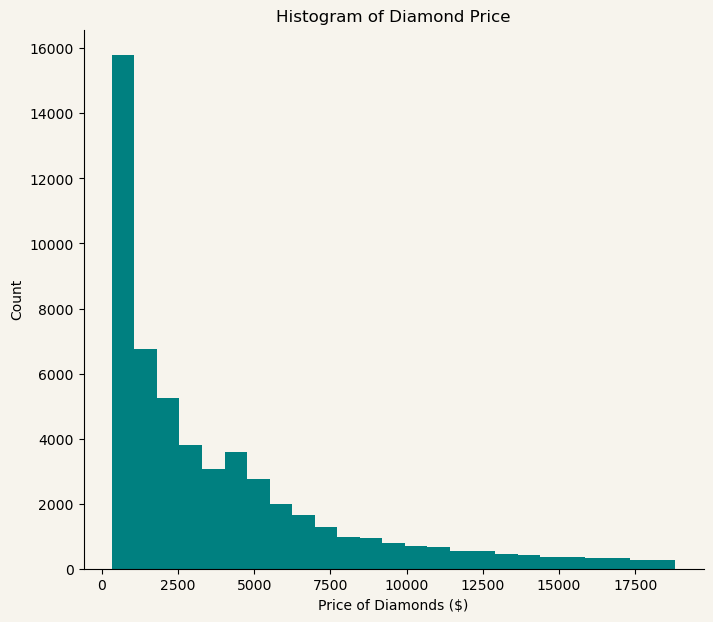

In [11]:
fig, ax = plt.subplots(figsize=(8, 7))

ax.hist(raw_df["price"], bins=25, color='teal')
ax.set_xlabel('Price of Diamonds ($)')
ax.set_ylabel("Count")

ax.set_title("Histogram of Diamond Price")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor(color='#f7f4ed')
fig.patch.set_facecolor('#f7f4ed')

plt.show()

#### Categorical Predictors

cut

Can mention bias towards ideal, premium, and very good. Data imbalance of dummy variables

In [8]:
cut_df = raw_df.groupby(['cut']).count()

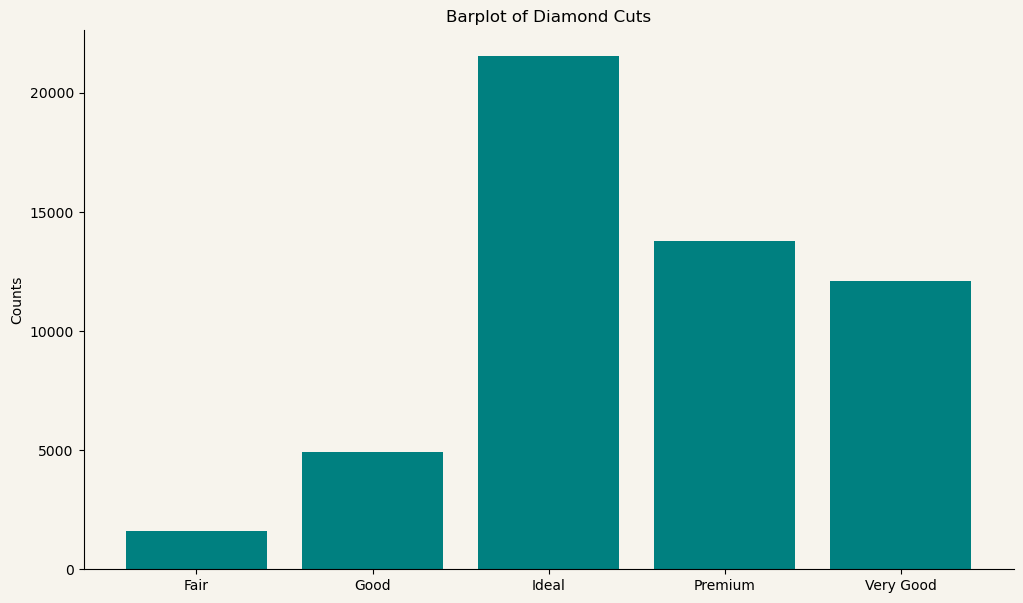

In [9]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.bar(cut_df.index, cut_df["x"], color='teal')
ax.set_ylabel('Counts')
ax.set_title("Barplot of Diamond Cuts")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor(color='#f7f4ed')
fig.patch.set_facecolor('#f7f4ed')

plt.show()

color

In [10]:
color_df = raw_df.groupby(['color']).count()

In [11]:
# reverse since J is worst grade diamond while D is best
color_df = color_df.reindex(index=color_df.index[::-1])

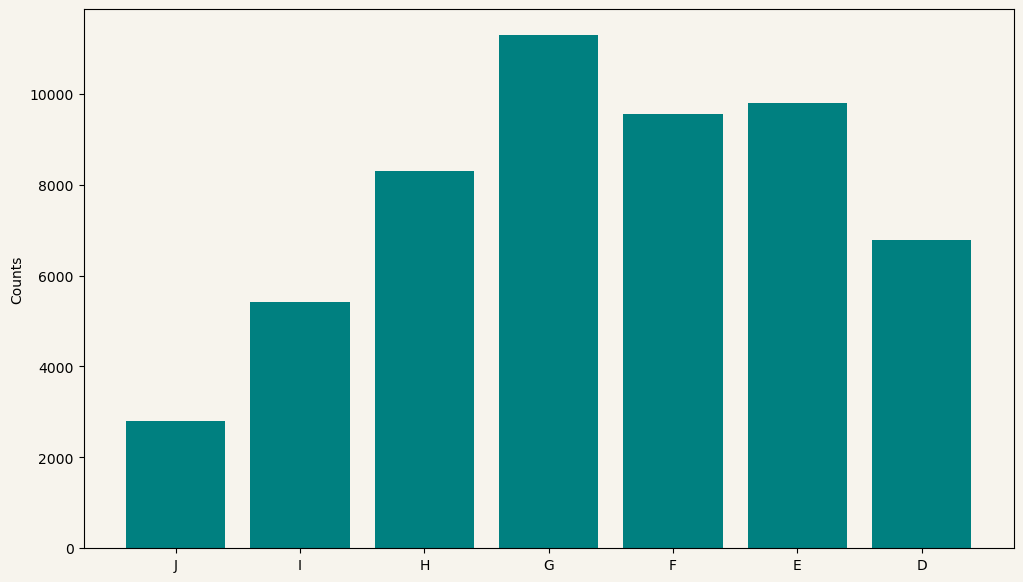

In [67]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.bar(color_df.index, color_df["x"], color='teal')
ax.set_ylabel('Counts')
ax.set_facecolor(color='#f7f4ed')
fig.patch.set_facecolor('#f7f4ed')
plt.show()

clarity

Can mention bias towards S11, S12, VS1, VS2. Data imbalance of dummy variables

In [13]:
clarity_df = raw_df.groupby(['clarity']).count()

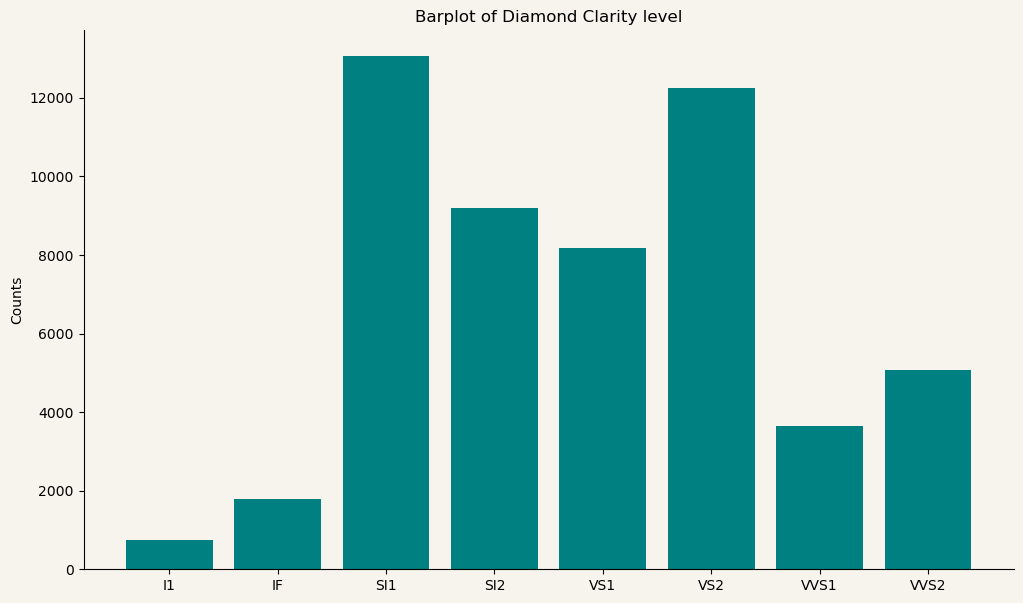

In [14]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.bar(clarity_df.index, clarity_df["x"], color='teal')
ax.set_ylabel('Counts')
ax.set_title("Barplot of Diamond Clarity level")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor(color='#f7f4ed')
fig.patch.set_facecolor('#f7f4ed')
plt.show()

#### Numerical Predictors

carat

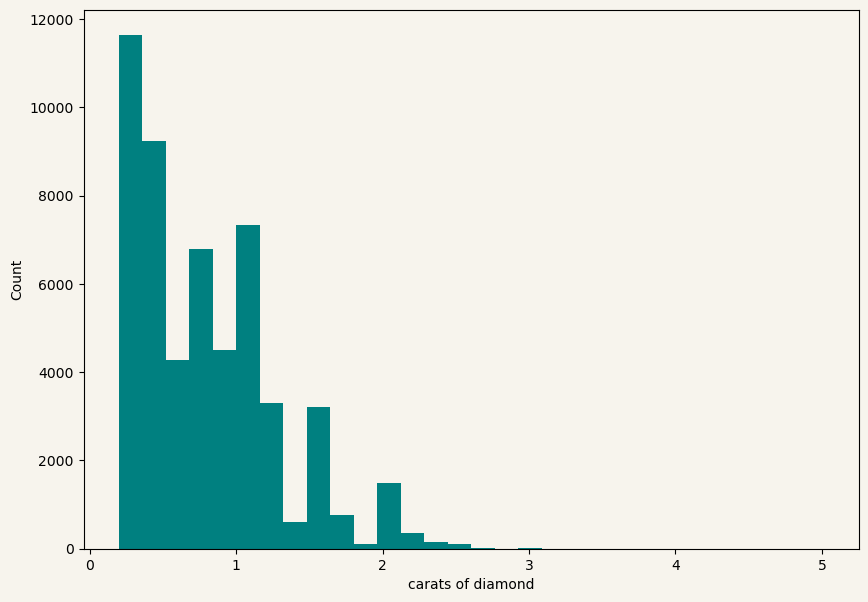

In [65]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.hist(raw_df["carat"], bins=30, color='teal')
ax.set_xlabel('carats of diamond')
ax.set_ylabel("Count")
ax.set_facecolor(color='#f7f4ed')
fig.patch.set_facecolor('#f7f4ed')
plt.show()

depth

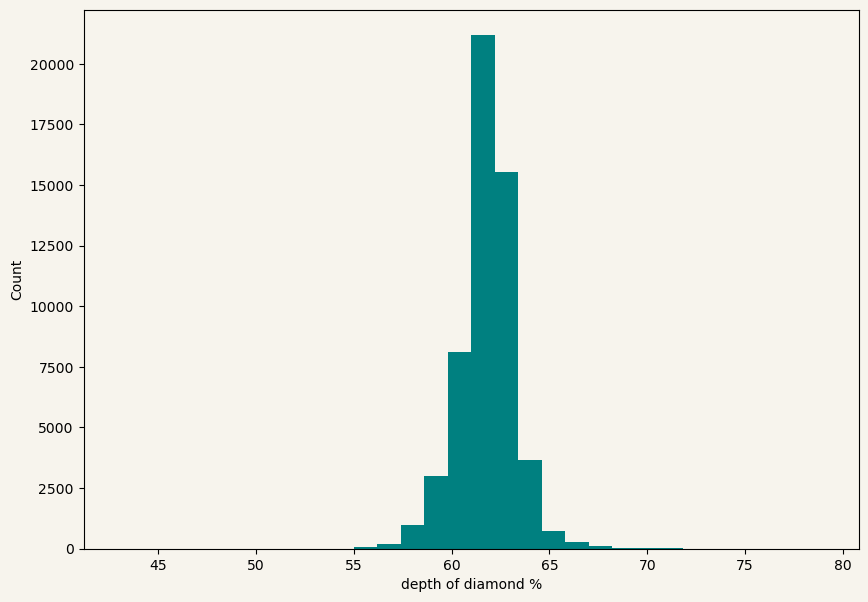

In [75]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.hist(raw_df["depth"], bins=30, color="teal")
ax.set_xlabel('depth of diamond %')
ax.set_ylabel("Count")
ax.set_facecolor(color='#f7f4ed')
fig.patch.set_facecolor('#f7f4ed')
plt.show()

table

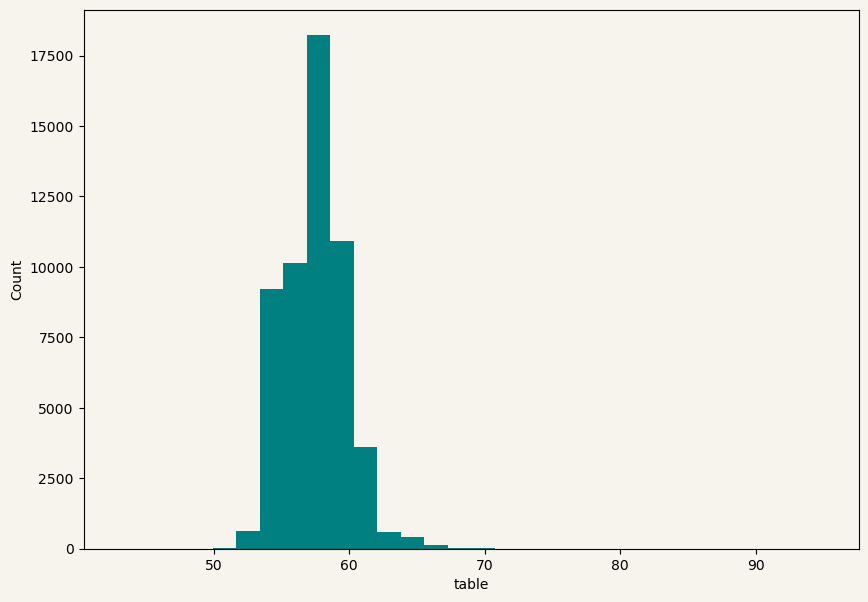

In [68]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.hist(raw_df["table"], bins=30, color="teal")
ax.set_xlabel('table')
ax.set_ylabel("Count")
ax.set_facecolor(color='#f7f4ed')
fig.patch.set_facecolor('#f7f4ed')
plt.show()

# Modelling and Model Diagnostic

#### Check for multicolinearity

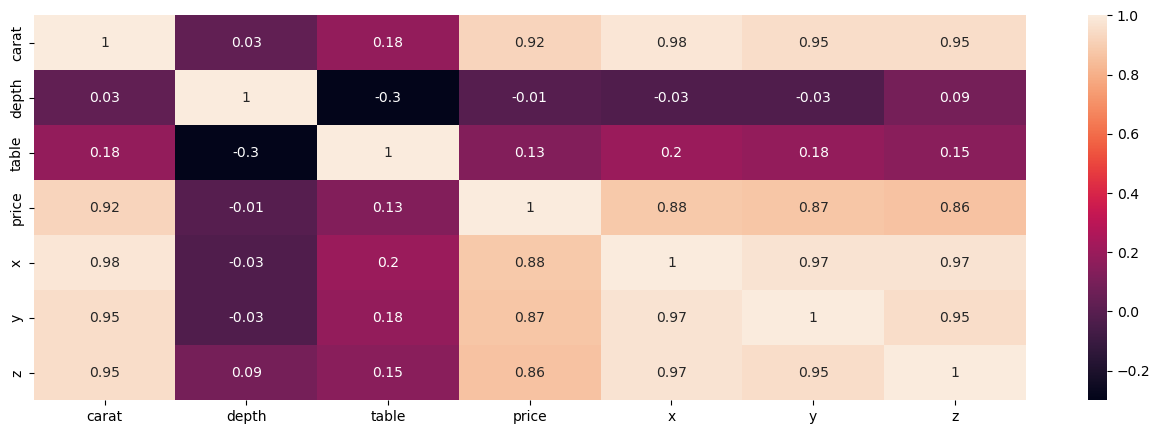

In [18]:
correlation_matrix = raw_df.corr().round(2)
plt.figure(figsize = (16,5))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

Seems that x, y, z are highly correlated with each other and carats. We can remove these columns from the dataset and not use them in our modelling.

In [19]:
# VIF

y, X = dmatrices('price ~ carat + cut + color + clarity + depth + table + x + y + z', data=raw_df, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

     VIF Factor          features
0   7037.529916         Intercept
1      3.940574       cut[T.Good]
2     11.308678      cut[T.Ideal]
3      8.348051    cut[T.Premium]
4      7.631051  cut[T.Very Good]
5      2.009954        color[T.E]
6      2.013118        color[T.F]
7      2.194151        color[T.G]
8      1.951752        color[T.H]
9      1.710211        color[T.I]
10     1.423173        color[T.J]
11     3.527903     clarity[T.IF]
12    14.759699    clarity[T.SI1]
13    11.466553    clarity[T.SI2]
14    10.772677    clarity[T.VS1]
15    14.263817    clarity[T.VS2]
16     5.933726   clarity[T.VVS1]
17     7.557383   clarity[T.VVS2]
18    22.439582             carat
19     1.782401             depth
20     1.787765             table
21    57.518327                 x
22    20.592160                 y
23    23.585582                 z


In [20]:
y, X = dmatrices('price ~ carat + cut + color + clarity + depth + table', data=raw_df, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

     VIF Factor          features
0   5629.457143         Intercept
1      3.934286       cut[T.Good]
2     11.292769      cut[T.Ideal]
3      8.340531    cut[T.Premium]
4      7.609453  cut[T.Very Good]
5      2.009883        color[T.E]
6      2.010686        color[T.F]
7      2.192379        color[T.G]
8      1.951692        color[T.H]
9      1.709013        color[T.I]
10     1.421333        color[T.J]
11     3.524652     clarity[T.IF]
12    14.725833    clarity[T.SI1]
13    11.446658    clarity[T.SI2]
14    10.761532    clarity[T.VS1]
15    14.249848    clarity[T.VS2]
16     5.928563   clarity[T.VVS1]
17     7.554621   clarity[T.VVS2]
18     1.323098             carat
19     1.378257             depth
20     1.786714             table


In [21]:
y, X = dmatrices('price ~ carat + color + depth + table', data=raw_df, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

    VIF Factor    features
0  3550.669027   Intercept
1     2.002040  color[T.E]
2     1.986866  color[T.F]
3     2.120526  color[T.G]
4     1.925416  color[T.H]
5     1.680767  color[T.I]
6     1.403148  color[T.J]
7     1.145777       carat
8     1.106032       depth
9     1.143033       table


When a dummy variable that represents more than two categories has a high VIF, multicollinearity does not necessarily exist. The variables will always have high VIFs if there is a small portion of cases in the category. As we can see from the barplots earlier, the data imbalance of the dummy variables in 'cut' and 'clarity' is causing the high VIF value. Given that Dummy variables must be included together to get the full information of the predictor, I will remove them from modelling.

#### Check for Influential Points

In [22]:
# I will use all the remaining predictors except for x, y, z
model = smf.ols('price ~ carat + color + depth + table', data=raw_df).fit()

In [23]:
influence = model.get_influence()
pd.Series(influence.hat_matrix_diag).describe()

count    53940.000000
mean         0.000185
std          0.000106
min          0.000089
25%          0.000127
50%          0.000157
75%          0.000204
max          0.005530
dtype: float64

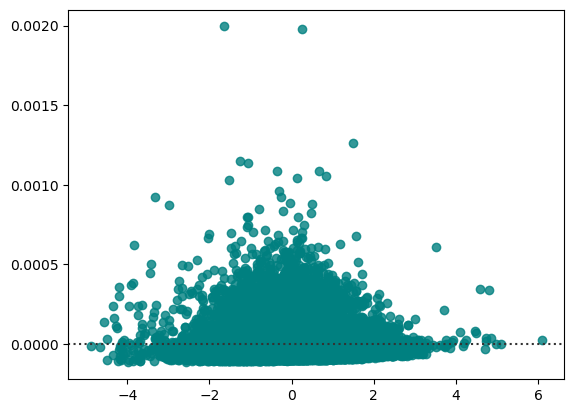

In [70]:
studentized_residuals = olsi(model).resid_studentized
keep_observ_at_indx = [i for i in studentized_residuals if abs(i) > 3] # applying the above mentioned thumb rule
leverage_pts = olsi(model).hat_matrix_diag        # this will give the array of leverage values
sns.residplot(x = studentized_residuals, y = leverage_pts, color = 'teal')
ax.set_facecolor(color='#f7f4ed')
fig.patch.set_facecolor('#f7f4ed')
plt.show()

In [25]:
cook_dist = dict(olsi(model).cooks_distance[0])

Check which rows have large Cook's Distance and remove them when D > 4/n <br>
Seems like 3422 points are influence points.

In [26]:
indx_list = []

for key, val in cook_dist.items():
    if np.abs(val) > 4/len(raw_df):
        indx_list.append(key)

len(indx_list)

3422

In [27]:
f'''Around {np.round(100*len(indx_list)/len(raw_df), 2)}% of the datapoints are influence points'''

'Around 6.34% of the datapoints are influence points'

In [28]:
clean_df = raw_df.drop(raw_df.index[indx_list]).copy()
len(clean_df)

50518

#### Initial Fit of Model

In [29]:
model = smf.ols('price ~ carat + color + depth + table', data=clean_df).fit()

- All predictors seem to be significant here except for color[T.G] from t-test, does not matter since it is dummy 
- pretty good R-square and adj-R-square, no penalty there
- F-stat looks good

In [30]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                 6.189e+04
Date:                Mon, 17 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:57:55   Log-Likelihood:            -4.1749e+05
No. Observations:               50518   AIC:                         8.350e+05
Df Residuals:                   50508   BIC:                         8.351e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8682.3304    260.086     33.383      0.000    8172.559    9192.102
color[T.E]   -54.1139     15.249     -3.549      0.000     -84.002     -24.226
color[T.F]   -68.9655     15.407     -4.476      0.000     -99.163     -38.768
color[T.G]    28.2574     14.900      1.896      0.058      -0.947      57.462
color[T.H]  -437.7980     16.020    -27.327      0.000    -469.198    -406.398
color[T.I]  -725.1573     18.076    -40.116      0.000    -760.587    -689.727
color[T.J] -1482.0010     23.089    -64.186      0.000   -1527.256   -1436.746
carat       7655.1486     10.642    719.305      0.000    7634.289    7676.008
depth        -97.3940      3.236    -30.096      0.000    -103.737     -91.051
table        -82.7345      2.033    -40.689      0.000     -86.720     -78.749
==============================================================================
Omnibus:                     4559.473   Durbin-Watson:                   0.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8404.588
Skew:                           0.628   Prob(JB):                         0.00
Kurtosis:                       4.553   Cond. No.                     5.25e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

All 4 predictors are significant as well in ANOVA

In [31]:
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
color,6.0,2.591525e+10,4.319208e+09,4893.948596,0.000000e+00
carat,1.0,4.639249e+11,4.639249e+11,525657.566903,0.000000e+00
depth,1.0,2.981323e+08,2.981323e+08,337.803593,3.379620e-75
table,1.0,1.461148e+09,1.461148e+09,1655.577784,0.000000e+00
Residual,50508.0,4.457639e+10,8.825611e+05,NaN,NaN


#### Check for Heteroscedasticity

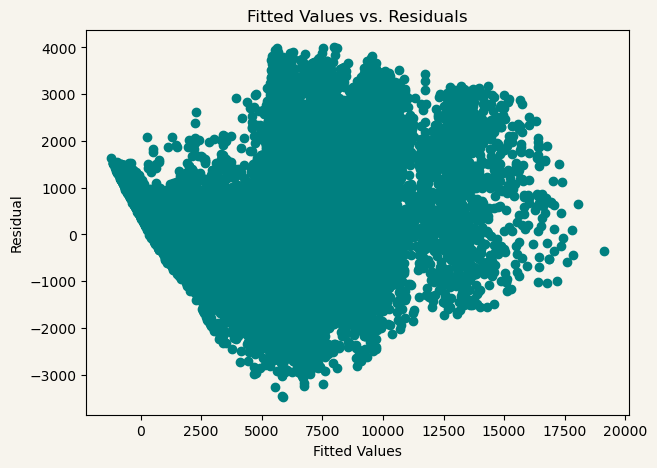

In [32]:
p = model.fittedvalues
res = model.resid

fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(p,res, color='teal')
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residual")
ax.set_title("Fitted Values vs. Residuals")
ax.set_facecolor(color='#f7f4ed')
fig.patch.set_facecolor('#f7f4ed')
plt.show()

low p-value of Breush-Pagan test suggest significant heteroscedaasticity

In [33]:
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 11057.306411100177, 'LM-Test p-value': 0.0}


In [34]:
clean_df['log_price']=np.log(clean_df['price']+1)
raw_df['log_price']=np.log(raw_df['price']+1)

In [35]:
model_1 =smf.ols('log_price ~ carat + color + depth + table', data=clean_df).fit()

Log-transformation did not improve heteroscedasticity, made it worse actually. Stick with non-log model for now

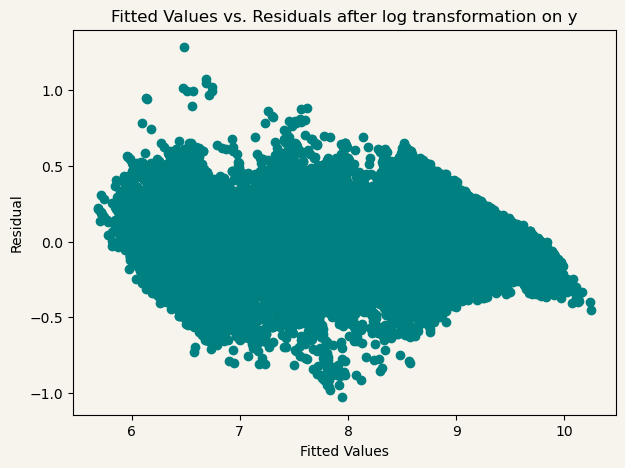

In [74]:
p1 = model_1.fittedvalues
res1 = model_1.resid

fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(p1,res1, color="teal")
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residual")
ax.set_title("Fitted Values vs. Residuals after log transformation on y")
ax.set_facecolor(color='#f7f4ed')
fig.patch.set_facecolor('#f7f4ed')
plt.show()

#### Check for Normality

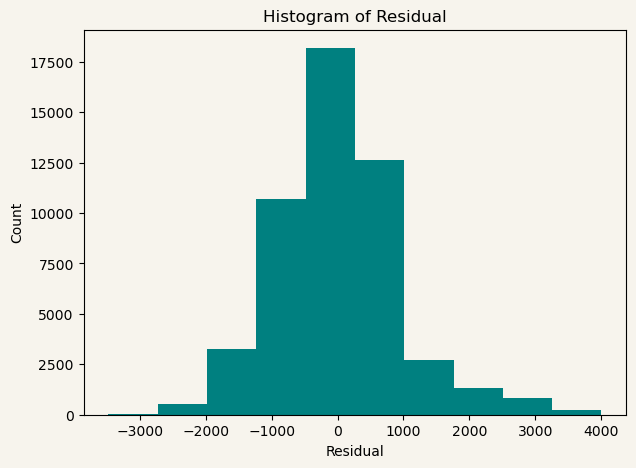

In [37]:
fig, ax = plt.subplots(figsize=(7,5))
ax.hist(model.resid, color='teal')
ax.set_xlabel("Residual")
ax.set_ylabel("Count")
ax.set_title("Histogram of Residual")
ax.set_facecolor(color='#f7f4ed')
fig.patch.set_facecolor('#f7f4ed')
plt.show()

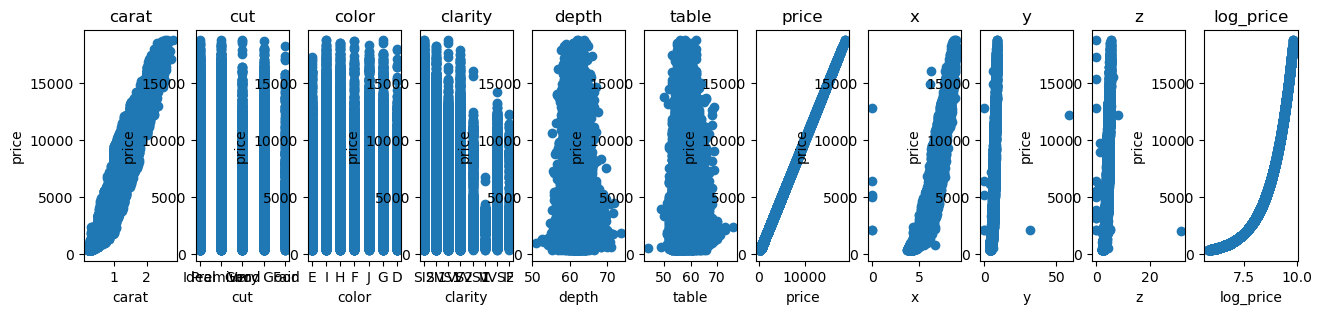

In [38]:
# Nonlinearity beween y and x
#pair-wise scatter plot between y and predictors
plt.figure(figsize=(20, 3))


# i: index
for i, col in enumerate(clean_df.columns):
    plt.subplot(1, 14, i+1)
    x = clean_df[col]
    y = clean_df['price']
    plt.plot(x, y, 'o')

    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('price')

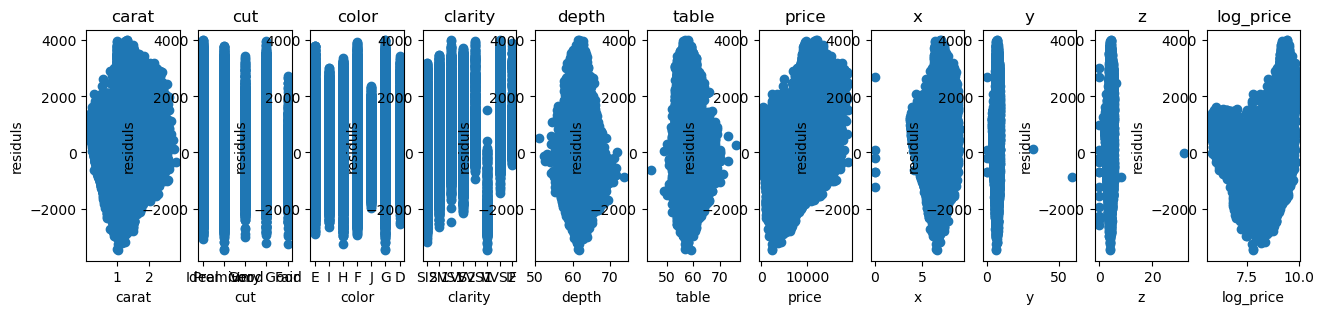

In [39]:
#residual plot might have suggestions too
#pair-wise scatter plot between residuals and predictors
plt.figure(figsize=(20, 3))


# i: index
for i, col in enumerate(clean_df.columns):
    plt.subplot(1, 14, i+1)
    x = clean_df[col]
    y = model.resid
    plt.plot(x, y, 'o')

    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('residuls')

In [40]:
# applying a log transformation on the numerical predictors to see if this improves normality

clean_df['log_carat']=np.log(raw_df['carat'])
clean_df['log_table']=np.log(raw_df['table'])
clean_df['log_depth']=np.log(raw_df['depth'])

raw_df['log_carat']=np.log(raw_df['carat'])
raw_df['log_table']=np.log(raw_df['table'])
raw_df['log_depth']=np.log(raw_df['depth'])

In [41]:
model_2 = smf.ols('log_price ~ log_carat + color + depth + table', data=clean_df).fit()

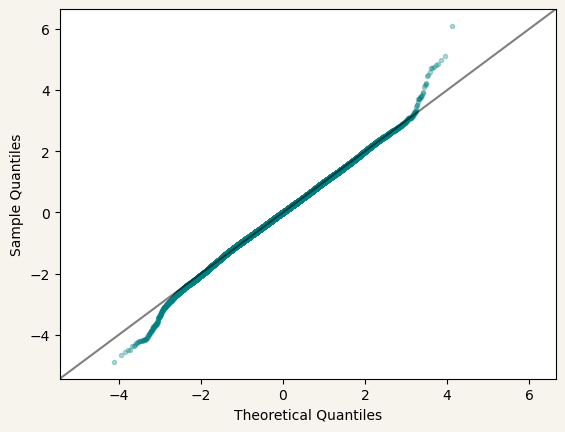

In [42]:
pp = sm.ProbPlot(model_2.resid, fit=True)
qq = pp.qqplot(marker='.', markerfacecolor='teal', markeredgecolor='teal', alpha=0.3)
sm.qqline(qq.axes[0], line='45', fmt='k--', alpha=0.5)
qq.patch.set_facecolor('#f7f4ed')
plt.show()

In [43]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                 1.105e+05
Date:                Mon, 17 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:57:58   Log-Likelihood:                 7119.6
No. Observations:               50518   AIC:                        -1.422e+04
Df Residuals:                   50508   BIC:                        -1.413e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.9203      0.059    186.092      0.000      10.805      11.035
color[T.E]    -0.0200      0.003     -5.857      0.000      -0.027      -0.013
color[T.F]    -0.0325      0.003     -9.414      0.000      -0.039      -0.026
color[T.G]    -0.0411      0.003    -12.327      0.000      -0.048      -0.035
color[T.H]    -0.1613      0.004    -45.123      0.000      -0.168      -0.154
color[T.I]    -0.2601      0.004    -64.612      0.000      -0.268      -0.252
color[T.J]    -0.3895      0.005    -75.886      0.000      -0.400      -0.379
log_carat      1.7315      0.002    965.059      0.000       1.728       1.735
depth         -0.0228      0.001    -31.473      0.000      -0.024      -0.021
table         -0.0166      0.000    -36.487      0.000      -0.018      -0.016
==============================================================================
Omnibus:                      224.209   Durbin-Watson:                   1.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              300.440
Skew:                          -0.053   Prob(JB):                     5.76e-66
Kurtosis:                       3.363   Cond. No.                     5.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

After log y(price) and log carat, the normality QQ-plot improved and the residual plot shows improvement from heteroscedasticity as well.

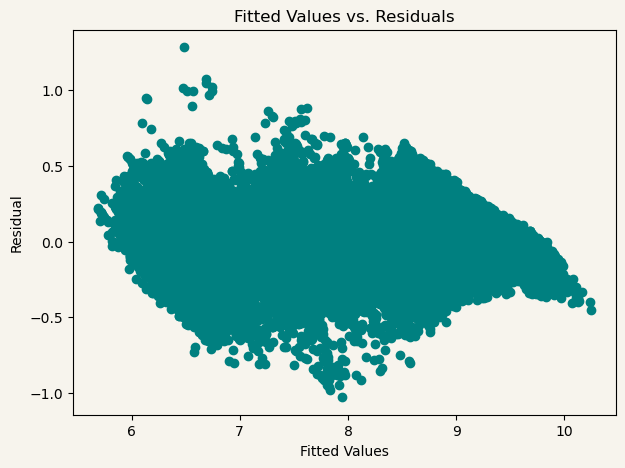

In [44]:
p1 = model_2.fittedvalues
res1 = model_2.resid

fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(p1,res1, color='teal')
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residual")
ax.set_title("Fitted Values vs. Residuals")
ax.set_facecolor(color='#f7f4ed')
fig.patch.set_facecolor('#f7f4ed')
plt.show()

#### Model Selection

In [45]:
model = smf.ols('log_price ~ log_carat + color + depth + table', data=clean_df).fit()

In [46]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                 1.105e+05
Date:                Mon, 17 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:57:59   Log-Likelihood:                 7119.6
No. Observations:               50518   AIC:                        -1.422e+04
Df Residuals:                   50508   BIC:                        -1.413e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.9203      0.059    186.092      0.000      10.805      11.035
color[T.E]    -0.0200      0.003     -5.857      0.000      -0.027      -0.013
color[T.F]    -0.0325      0.003     -9.414      0.000      -0.039      -0.026
color[T.G]    -0.0411      0.003    -12.327      0.000      -0.048      -0.035
color[T.H]    -0.1613      0.004    -45.123      0.000      -0.168      -0.154
color[T.I]    -0.2601      0.004    -64.612      0.000      -0.268      -0.252
color[T.J]    -0.3895      0.005    -75.886      0.000      -0.400      -0.379
log_carat      1.7315      0.002    965.059      0.000       1.728       1.735
depth         -0.0228      0.001    -31.473      0.000      -0.024      -0.021
table         -0.0166      0.000    -36.487      0.000      -0.018      -0.016
==============================================================================
Omnibus:                      224.209   Durbin-Watson:                   1.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              300.440
Skew:                          -0.053   Prob(JB):                     5.76e-66
Kurtosis:                       3.363   Cond. No.                     5.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
color,6.0,1586.455618,264.409270,5985.176576,0.000000e+00
log_carat,1.0,42285.226660,42285.226660,957169.725824,0.000000e+00
depth,1.0,19.723907,19.723907,446.470971,1.132496e-98
table,1.0,58.812970,58.812970,1331.292245,1.006730e-287
Residual,50508.0,2231.309840,0.044177,NaN,NaN


In [48]:
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
color,508.248048,6.0,1917.453144,0.000000e+00
log_carat,41144.049467,1.0,931338.002850,0.000000e+00
depth,43.758990,1.0,990.529881,2.505464e-215
table,58.812970,1.0,1331.292245,1.006730e-287
Residual,2231.309840,50508.0,NaN,NaN


In [49]:
sm.stats.anova_lm(model, typ=3)

,sum_sq,df,F,PR(>F)
Intercept,1529.873475,1.0,34630.264281,0.000000e+00
color,508.248048,6.0,1917.453144,0.000000e+00
log_carat,41144.049467,1.0,931338.002850,0.000000e+00
depth,43.758990,1.0,990.529881,2.505464e-215
table,58.812970,1.0,1331.292245,1.006730e-287
Residual,2231.309840,50508.0,NaN,NaN


Log_carat seems to be the most significant predictor, followed by color, table, then depth

In [50]:
model_1 = smf.ols('log_price ~ log_carat + color + depth + table', data=clean_df).fit()

model_2 = smf.ols('log_price ~ log_carat + color + depth', data=clean_df).fit()
model_3 = smf.ols('log_price ~ log_carat + color + table', data=clean_df).fit()
model_4 = smf.ols('log_price ~ log_carat + table + depth', data=clean_df).fit()
model_5 = smf.ols('log_price ~ color + depth + table', data=clean_df).fit()


model_6 = smf.ols('log_price ~ log_carat + color', data=clean_df).fit()
model_7 = smf.ols('log_price ~ log_carat + table', data=clean_df).fit()
model_8 = smf.ols('log_price ~ log_carat + depth', data=clean_df).fit()
model_9 = smf.ols('log_price ~ color + table', data=clean_df).fit()
model_10 = smf.ols('log_price ~ color + depth', data=clean_df).fit()
model_11 = smf.ols('log_price ~ depth + table', data=clean_df).fit()

model_12 = smf.ols('log_price ~ depth', data=clean_df).fit()
model_13 = smf.ols('log_price ~ table', data=clean_df).fit()
model_14 = smf.ols('log_price ~ log_carat', data=clean_df).fit()
model_15 = smf.ols('log_price ~ color', data=clean_df).fit()

#### Check R2, adj_R2, Mallow's CP:

In [51]:
model_number = [i for i in range(1,16)]
models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, model_9, model_10, model_11, model_12, model_13, model_14, model_15]
r_2 = [i.rsquared for i in models]
adj_r2 = [i.rsquared_adj for i in models]

In [52]:
mallow_cp = []
n = len(clean_df)
y_pred_full = model_1.predict()
mse_full = np.square(np.subtract(clean_df['log_price'], y_pred_full)).sum()/(n-5)


k = [5, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2]

for i in range(15):
    y_pred = models[i].predict()
    sse = sum(np.square(np.subtract(clean_df['log_price'], y_pred)))
    mallow_cp.append(sse/mse_full - (n-2*k[i]))

In [53]:

model_pool_df = pd.DataFrame(list(zip(model_number, r_2, adj_r2, mallow_cp, k)),
               columns =['model', 'r2', 'adj_r2', 'mallows_cp', 'k_val']) 

model 1 has best performance looking at adj-r2 and mallows CP

In [54]:
model_pool_df

,model,r2,adj_r2,mallows_cp,k_val
0,1,0.951684,0.951675,5.000000,5
1,2,0.950410,0.950403,1334.424035,4
2,3,0.950736,0.950729,993.627937,4
3,4,0.940678,0.940675,11508.857762,4
4,5,0.060764,0.060615,931433.199928,4
5,6,0.949983,0.949976,1778.939204,3
6,7,0.939520,0.939517,12718.420830,3
7,8,0.939466,0.939464,12774.470563,3
8,9,0.058492,0.058361,933806.698446,3
9,10,0.034355,0.034221,959040.638157,3


#### Check stepwise AIC and BIC

model 1 has best performance using AIC

In [55]:
AIC = [i.aic for i in models]
aic_df = pd.DataFrame(list(zip(model_number, AIC)),
               columns =['model', 'AIC']) 
aic_df.sort_values(by=['AIC']).head()

,model,AIC
0,1,-14219.198308
2,3,-13240.061875
1,2,-12906.888693
5,6,-12475.660424
3,4,-3864.512316


model 1 has best performance using BIC

In [56]:
BIC = [i.bic for i in models]
bic_df = pd.DataFrame(list(zip(model_number, BIC)),
               columns =['model', 'BIC']) 
bic_df.sort_values(by=['BIC']).head()

,model,BIC
0,1,-14130.897458
2,3,-13160.591110
1,2,-12827.417928
5,6,-12405.019745
3,4,-3829.191976


# Final Model

'log_price ~ log_carat + color + depth + table' is the final model we will use

In [57]:
model = smf.ols('log_price ~ log_carat + color + depth + table', data=clean_df).fit()

In [76]:
# Still some heteroscedasticity

bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 1655.7866746247998, 'LM-Test p-value': 0.0}


In [58]:
# with influential points
inf_model = smf.ols('log_price ~ log_carat + color + depth + table', data=raw_df).fit()

In [60]:
inf_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                 1.078e+05
Date:                Mon, 17 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:58:00   Log-Likelihood:                 2115.1
No. Observations:               53940   AIC:                            -4210.
Df Residuals:                   53930   BIC:                            -4121.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.2225      0.060    186.548      0.000      11.105      11.340
color[T.E]    -0.0247      0.004     -6.712      0.000      -0.032      -0.017
color[T.F]    -0.0355      0.004     -9.602      0.000      -0.043      -0.028
color[T.G]    -0.0579      0.004    -16.155      0.000      -0.065      -0.051
color[T.H]    -0.1883      0.004    -48.982      0.000      -0.196      -0.181
color[T.I]    -0.2857      0.004    -66.426      0.000      -0.294      -0.277
color[T.J]    -0.4206      0.005    -79.133      0.000      -0.431      -0.410
log_carat      1.7427      0.002    958.257      0.000       1.739       1.746
depth         -0.0258      0.001    -34.998      0.000      -0.027      -0.024
table         -0.0183      0.000    -38.172      0.000      -0.019      -0.017
==============================================================================
Omnibus:                     1430.335   Durbin-Watson:                   1.242
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3253.319
Skew:                          -0.118   Prob(JB):                         0.00
Kurtosis:                       4.180   Cond. No.                     5.07e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Improvement in R-squared, AIC/BIC, JB stat of non-influential points model compared to the model with influential points

In [61]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                 1.105e+05
Date:                Mon, 17 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:58:00   Log-Likelihood:                 7119.6
No. Observations:               50518   AIC:                        -1.422e+04
Df Residuals:                   50508   BIC:                        -1.413e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.9203      0.059    186.092      0.000      10.805      11.035
color[T.E]    -0.0200      0.003     -5.857      0.000      -0.027      -0.013
color[T.F]    -0.0325      0.003     -9.414      0.000      -0.039      -0.026
color[T.G]    -0.0411      0.003    -12.327      0.000      -0.048      -0.035
color[T.H]    -0.1613      0.004    -45.123      0.000      -0.168      -0.154
color[T.I]    -0.2601      0.004    -64.612      0.000      -0.268      -0.252
color[T.J]    -0.3895      0.005    -75.886      0.000      -0.400      -0.379
log_carat      1.7315      0.002    965.059      0.000       1.728       1.735
depth         -0.0228      0.001    -31.473      0.000      -0.024      -0.021
table         -0.0166      0.000    -36.487      0.000      -0.018      -0.016
==============================================================================
Omnibus:                      224.209   Durbin-Watson:                   1.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              300.440
Skew:                          -0.053   Prob(JB):                     5.76e-66
Kurtosis:                       3.363   Cond. No.                     5.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""